In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc='My bar!')
import numpy as np
import time
import matplotlib.pyplot as plt 

In [116]:
df = pd.read_excel('clinical_notes_hourly.xlsx')
print(df.columns)

Index(['icustay_id', 'hr', 'category', 'description', 'text'], dtype='object')


In [117]:
df.dropna(subset=['category', 'description'], how='all', inplace=True)

In [118]:
df.head(20)

,icustay_id,hr,category,description,text
1,200039,2,Nursing/other,Report,CCU NSG ADMIT NOTE-NSICU BORDER.\n69 YO [**Hos...
11,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...
13,200039,14,Nursing/other,Report,"npn ccu\nn-fc's, mae's, slow to respond but do..."
40,200052,17,Nursing/other,Report,NURSING NOTE (1900-0700)\n\nMrs. [**Known last...
43,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...
53,200072,6,Nursing,Nursing Progress Note,Intracerebral hemorrhage (ICH)\n Assessment:...
54,200072,6,Nursing,Nursing Progress Note,Intracerebral hemorrhage (ICH)\n Assessment:...
55,200072,6,Nursing,Nursing Progress Note,Intracerebral hemorrhage (ICH)\n Assessment:...
56,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...
57,200072,7,Physician,Intensivist Note,SICU\n HPI:\n 55M with no PMHx who reports...


In [119]:
# 'text' column is an object but not all strings
df['text'] = df['text'].astype(str)

# Objective is to summarize the reports, extracting the important information

In [120]:
report = df.loc[77, 'text'] #77
print(report)

[**2106-3-25**] 1:18 PM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 53995**]
 Reason: eval for pneumothorax s/p chest tube removal
 Admitting Diagnosis: CEREBELLAR HEMORRHAGE
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  55 year old man s/p CABG
 REASON FOR THIS EXAMINATION:
  eval for pneumothorax s/p chest tube removal
 ______________________________________________________________________________
                                 FINAL REPORT
 PORTABLE CHEST, [**2106-3-25**]

 COMPARISON:  [**2105-3-23**].

 INDICATION:  Chest tube removal.

 Various indwelling devices have been removed in the interval and a right
 internal jugular catheter has been placed within the superior vena cava.  No
 pneumothorax.  Cardiomediastinal contours are widened but unchanged in the
 post-operative setting.  A crescenteric lucency is present adjacent to the
 aortic knob and m

In [121]:
len(report.split())

142

In [122]:
# dropping all rows that are not 'Radiology'
df.drop(df[df['category'] != 'Radiology'].index, inplace = True)
df.head()

,icustay_id,hr,category,description,text
11,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...
43,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...
56,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...
59,200072,8,Radiology,MR HEAD W & W/O CONTRAST,[**2106-3-4**] 5:26 AM\n MR HEAD W & W/O CONTR...
60,200072,8,Radiology,MR HEAD W & W/O CONTRAST,"[**Last Name (LF) 477**],[**First Name3 (LF) 4..."


In [123]:
df.shape

(4882, 5)

# Cleaning step 1 - removing non-informative text

In [125]:
import re

def custom_cleaner(text):
  text = re.sub('\s+', ' ', text).strip()
  text = re.sub(r'\n\.', ' ', text)
  # regular expression to match all substrings between square brackets
  pattern = r"\[.*?\]"
    
  # substitute all matches with an empty string
  text = re.sub(pattern, "", text)

  # Remove time stamps
  text = re.sub(r'\d+:\d+\s*(?:AM|PM)', '', text)

  # Remove all characters except alphabets, full stop, and colon
  text = re.sub(r'[^a-zA-Z0-9.:\s]', '', text)

  colon_index = text.find(':')
  if colon_index != -1:
      text = text[0:colon_index+1] + text[colon_index+1:].split(':', 1)[1]

  words = text.split()
  output = ""
  colon_found = False

  for word in words:
      if ":" in word:
          output += word + " "
          colon_found = True
      elif colon_found:
          output += word + " "
  if output != "":
    text = output
  return text


In [126]:
report_clean2 = custom_cleaner(report)

In [127]:
len(report_clean2.split())

116

In [128]:
report_clean2

'Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITION: 55 year old man sp CABG REASON FOR THIS EXAMINATION: eval for pneumothorax sp chest tube removal FINAL REPORT PORTABLE CHEST COMPARISON: . INDICATION: Chest tube removal. Various indwelling devices have been removed in the interval and a right internal jugular catheter has been placed within the superior vena cava. No pneumothorax. Cardiomediastinal contours are widened but unchanged in the postoperative setting. A crescenteric lucency is present adjacent to the aortic knob and may represent an area of normally aerated lung adjacent to linear left suprahilar atelectasis. Localized pneumomediastinum is considered less likely. Worsening bibasilar atelectasis and new small left pleural effusion are present as well as new moderate gastric distention. '

In [129]:
df2 = pd.read_csv('cleaned_radiology.csv')
print(df2.columns)

Index(['Unnamed: 0', 'icustay_id', 'hr', 'category', 'description', 'text',
       'mortality', 'cleaned_text'],
      dtype='object')


In [132]:
report2 = df2.loc[101, 'text']
print(report2)

[**2190-11-19**] 12:29 PM
 CT CHEST W/O CONTRAST; CT ABDOMEN W/O CONTRAST                  Clip # [**Clip Number (Radiology) 71847**]
 CT PELVIS W/O CONTRAST
 Reason: eval for evidence of traumatic injury
 Admitting Diagnosis: INTRACRANIAL HEMORRHAGE
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  63 year old woman with fall, on coumadin, intubated
 REASON FOR THIS EXAMINATION:
  eval for evidence of traumatic injury
 No contraindications for IV contrast
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  Fall while on Coumadin.

 COMPARISON:  None available.

 TECHNIQUE:  Axial CT images were acquired through the torso in the absence of
 intravenous contrast.  Coronal and sagittal reformatted images were also
 reviewed.

 CT CHEST WITHOUT CONTRAST:  The patient is intubated and the endotracheal tube
 terminates at the ostium of 

In [150]:
report2_T5 = df3.loc[101, 'summary_T5']
print(report2_T5)

63 year old woman with fall while on coumadin intubated. eval for evidence of traumatic injury no contraindications for IV contrast. lungs notable for diffuse groundglass density as well as intralobular septal thickening.


In [153]:
s = "Reason: INTRACRANIAL HEMORRHAGE MEDICAL CONDITION: 63 year old woman with fall on coumadin intubated REASON FOR THIS EXAMINATION: eval for evidence of traumatic injury No contraindications for IV contrast FINAL REPORT INDICATION: Fall while on Coumadin. COMPARISON: None available. TECHNIQUE: Axial CT images were acquired through the torso in the absence of intravenous contrast. Coronal and sagittal reformatted images were also reviewed. CT CHEST WITHOUT CONTRAST: The patient is intubated and the endotracheal tube terminates at the ostium of the right main stem bronchus and needs to be retracted. The lungs are notable for diffuse groundglass density as well as intralobular septal thickening"


In [154]:
len(s.split())

103

In [134]:
report_clean = custom_cleaner(report2)

In [135]:
report_clean

'Reason: INTRACRANIAL HEMORRHAGE MEDICAL CONDITION: 63 year old woman with fall on coumadin intubated REASON FOR THIS EXAMINATION: eval for evidence of traumatic injury No contraindications for IV contrast FINAL REPORT INDICATION: Fall while on Coumadin. COMPARISON: None available. TECHNIQUE: Axial CT images were acquired through the torso in the absence of intravenous contrast. Coronal and sagittal reformatted images were also reviewed. CT CHEST WITHOUT CONTRAST: The patient is intubated and the endotracheal tube terminates at the ostium of the right main stem bronchus and needs to be retracted. The lungs are notable for diffuse groundglass density as well as intralobular septal thickening and small bilateral pleural effusions overall suggestive of volume overload. In addition note is made of bibasilar consolidations possibly aspiration in an intubated patient though bilateral pneumonia would also be a consideration and these findings might be distinguished by the clinical history. Th

In [64]:
print(report2)

Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITION: 55 year old man sp CABG REASON FOR THIS EXAMINATION: eval for pneumothorax sp chest tube removal FINAL REPORT PORTABLE CHEST COMPARISON: . INDICATION: Chest tube removal. Various indwelling devices have been removed in the interval and a right internal jugular catheter has been placed within the superior vena cava. No pneumothorax. Cardiomediastinal contours are widened but unchanged in the postoperative setting. A crescenteric lucency is present adjacent to the aortic knob and may represent an area of normally aerated lung adjacent to linear left suprahilar atelectasis. Localized pneumomediastinum is considered less likely. Worsening bibasilar atelectasis and new small left pleural effusion are present as well as new moderate gastric distention. 


# Running the T5-base model on all cells

In [2]:
import transformers
import torch

# Load the T5 model
model = transformers.T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base', model_max_length=512)


/opt/anaconda3/envs/DataScience/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the input data
input_text2 = "Reason: WEAKNESS MEDICAL CONDITION: 58 year old man with apml with shortness of breath. REASON FOR THIS EXAMINATION: assess for effusions infiltrate cause for hct drop dah FINAL REPORT INDICATION: 58yearold with APML and shortness of breath. Evaluate for effusions and infiltrates or cause for hematocrit drop. COMPARISON: CT of the chest . SINGLE AP UPRIGHT BEDSIDE CHEST RADIOGRAPH: Compared to the CT and chest radiograph from one day prior there has been significant interval improvement of the right upper lobe opacity which may have been due to aspiration given its marked improvement. There is a new right infrahilar opacity which may represent pneumonia or hemorrhage. There is perihilar haze and indistinctness of the vasculature consistent with mild pulmonary edema. The cardiomediastinal silhouette is normal. IMPRESSION: 1. Improved right upper lobe opacity with new right perihilar opacity. This new opacity may represent pneumonia or hemorrhage given the patients hematocrit drop. 2. Mild fluid overload."



In [5]:
# Tokenize the input data
input_ids = tokenizer.encode("summarize: " +input_text2, max_length=512,truncation=True, padding='max_length', return_tensors='pt')

# Generate the summary
summary_ids = model.generate(input_ids, num_beams=4, max_length=500, early_stopping=False)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the summary
print("Summary:", summary)

Summary: 58 year old man with apml with shortness of breath. assess for effusions and infiltrates or cause for hematocrit drop. a new right infrahilar opacity may represent pneumonia or hemorrhage.


In [33]:
def sumarizer(text):
    # Tokenize the input data
    input_ids = tokenizer.encode("summarize: " +text, max_length=500,truncation=True, padding='max_length', return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(input_ids, num_beams=4, max_length=500, early_stopping=False)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Print the summary
    return summary


In [34]:
tentative = sumarizer(df2.loc[5, 'cleaned_text'])

In [35]:
len(tentative.split())

38

In [37]:
df2['summary_T5'] = df2['cleaned_text'].progress_apply(sumarizer)

My bar!: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4882/4882 [8:47:18<00:00,  6.48s/it]


In [38]:
df2.head()

,Unnamed: 0,icustay_id,hr,category,description,text,mortality,cleaned_text,summary_T5
0,0,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...,0,Reason: 69 year old woman sp decompressive sur...,69 year old woman sp decompressive surgery for...
1,1,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...,0,Reason: CEREBELLER HEMORRHAGE MEDICAL CONDITIO...,57 year old woman with cerebellar hemorrhage. ...
2,2,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...,0,Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITIO...,MEDICAL CONDITION: 55 year old male with left ...
3,3,200072,8,Radiology,MR HEAD W & W/O CONTRAST,[**2106-3-4**] 5:26 AM\n MR HEAD W & W/O CONTR...,0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,a 55 year old man with acute onset diplopia an...
4,4,200072,8,Radiology,MR HEAD W & W/O CONTRAST,"[**Last Name (LF) 477**],[**First Name3 (LF) 4...",0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,man with acute onset diplopia and imbalance hy...


In [42]:
# how many words in the text column
df2["Number_Words"] = df2["text"].apply(lambda n: len(n.split()))
df2.head()

,Unnamed: 0,icustay_id,hr,category,description,text,mortality,cleaned_text,summary_T5,Number_Words
0,0,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...,0,Reason: 69 year old woman sp decompressive sur...,69 year old woman sp decompressive surgery for...,184
1,1,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...,0,Reason: CEREBELLER HEMORRHAGE MEDICAL CONDITIO...,57 year old woman with cerebellar hemorrhage. ...,141
2,2,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...,0,Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITIO...,MEDICAL CONDITION: 55 year old male with left ...,202
3,3,200072,8,Radiology,MR HEAD W & W/O CONTRAST,[**2106-3-4**] 5:26 AM\n MR HEAD W & W/O CONTR...,0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,a 55 year old man with acute onset diplopia an...,244
4,4,200072,8,Radiology,MR HEAD W & W/O CONTRAST,"[**Last Name (LF) 477**],[**First Name3 (LF) 4...",0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,man with acute onset diplopia and imbalance hy...,96


In [43]:
df2["Number_Words"] = df2["text"].apply(lambda n: len(n.split()))
df2["Number_Words_T5"] = df2["summary_T5"].apply(lambda n: len(n.split()))
df2.head(20)

,Unnamed: 0,icustay_id,hr,category,description,text,mortality,cleaned_text,summary_T5,Number_Words,Number_Words_T5
0,0,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...,0,Reason: 69 year old woman sp decompressive sur...,69 year old woman sp decompressive surgery for...,184,22
1,1,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...,0,Reason: CEREBELLER HEMORRHAGE MEDICAL CONDITIO...,57 year old woman with cerebellar hemorrhage. ...,141,21
2,2,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...,0,Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITIO...,MEDICAL CONDITION: 55 year old male with left ...,202,29
3,3,200072,8,Radiology,MR HEAD W & W/O CONTRAST,[**2106-3-4**] 5:26 AM\n MR HEAD W & W/O CONTR...,0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,a 55 year old man with acute onset diplopia an...,244,40
4,4,200072,8,Radiology,MR HEAD W & W/O CONTRAST,"[**Last Name (LF) 477**],[**First Name3 (LF) 4...",0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,man with acute onset diplopia and imbalance hy...,96,22
5,5,200072,22,Radiology,CHEST (PORTABLE AP),[**2106-3-25**] 1:18 PM\n CHEST (PORTABLE AP) ...,0,Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITIO...,55 year old man sp CABG eval for pneumothorax ...,142,38
6,6,200103,15,Radiology,SEL CATH 3RD ORDER THOR,[**2201-5-18**] 10:55 AM\n CAROT/CEREB [**Hosp...,0,Reason: SUBARACHNOID HEMORRHAGE Contrast: OPTI...,58-year-old man with sAH had a 19gauge single ...,665,62
7,7,200131,16,Radiology,CT HEAD W/O CONTRAST,[**2176-10-31**] 5:25 AM\n CT HEAD W/O CONTRAS...,0,Reason: STROKETELEMETRYTRANSIENT ISCHEMIC ATTA...,pontine hemorrhage appears slightly larger in ...,164,20
8,8,200131,21,Radiology,CHEST (PORTABLE AP),[**2176-10-31**] 10:07 AM\n CHEST (PORTABLE AP...,0,Reason: STROKETELEMETRYTRANSIENT ISCHEMIC ATTA...,69 year old woman with pontine hemorrhage and ...,168,27
9,9,200131,21,Radiology,CHEST (PORTABLE AP),"[**Last Name (LF) **],[**First Name8 (NamePatt...",0,Reason: STROKETELEMETRYTRANSIENT ISCHEMIC ATTA...,69 year old woman with pontine hemorrhage feve...,79,25


In [44]:
df2.to_csv("t5resultsB.csv", index=False)

In [139]:
df3 = pd.read_csv('t5resultsB.csv')
df3.head()

,Unnamed: 0,icustay_id,hr,category,description,text,mortality,cleaned_text,summary_T5,Number_Words,Number_Words_T5
0,0,200039,12,Radiology,CT HEAD W/O CONTRAST,[**2121-12-26**] 4:56 PM\n CT HEAD W/O CONTRAS...,0,Reason: 69 year old woman sp decompressive sur...,69 year old woman sp decompressive surgery for...,184,22
1,1,200052,20,Radiology,CT HEAD W/O CONTRAST,[**2193-9-19**] 8:41 AM\n CT HEAD W/O CONTRAST...,0,Reason: CEREBELLER HEMORRHAGE MEDICAL CONDITIO...,57 year old woman with cerebellar hemorrhage. ...,141,21
2,2,200072,6,Radiology,CT HEAD W/O CONTRAST,[**2106-3-4**] 3:26 AM\n CT HEAD W/O CONTRAST ...,0,Reason: CEREBELLAR HEMORRHAGE MEDICAL CONDITIO...,MEDICAL CONDITION: 55 year old male with left ...,202,29
3,3,200072,8,Radiology,MR HEAD W & W/O CONTRAST,[**2106-3-4**] 5:26 AM\n MR HEAD W & W/O CONTR...,0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,a 55 year old man with acute onset diplopia an...,244,40
4,4,200072,8,Radiology,MR HEAD W & W/O CONTRAST,"[**Last Name (LF) 477**],[**First Name3 (LF) 4...",0,Reason: CEREBELLAR HEMORRHAGE Contrast: MAGNEV...,man with acute onset diplopia and imbalance hy...,96,22


In [143]:
df3.loc[101, 'Number_Words']

595

In [140]:
report2_T5 = df3.loc[101, 'summary_T5']
print(report2_T5)

63 year old woman with fall while on coumadin intubated. eval for evidence of traumatic injury no contraindications for IV contrast. lungs notable for diffuse groundglass density as well as intralobular septal thickening.


In [144]:
df3.loc[101, 'Number_Words_T5']

33

In [ ]:
#subplots=True

In [148]:
word_count = df3[['Number_Words','Number_Words_T5']].copy()

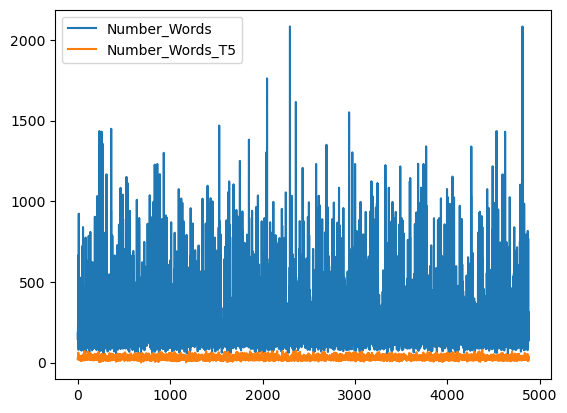

In [158]:
lines = word_count.plot.line()

# Playing with tokenizers

In [ ]:
clinical_text = "Patient presents with hyperlipidemia and hypertension, requiring further evaluation and management. Mild bilateral pleural effusions. No pneumothorax or pulmonary edema."


In [ ]:
regular_text = "I'm going to the grocery store to buy some milk and bread. The store name is supercalifragilisticexpialidocious"


In [ ]:
# T5
import transformers
import torch
model = transformers.T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base', model_max_length=512)

input_ids = tokenizer.encode(regular_text, return_tensors="pt")
input_ids2 = tokenizer.encode(clinical_text, return_tensors="pt")

print("Regular text:", regular_text)
print("Input tokens:", tokenizer.convert_ids_to_tokens(input_ids[0]))
print()
print("Medical text:", clinical_text)
print("Input tokens:", tokenizer.convert_ids_to_tokens(input_ids2[0]))

In [ ]:
# testing to see if a word is in the tokenizer vocabulary
#all words that are broken up were not in the vocabulary!
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')
word = "pneumothorax"

# Get the vocabulary dictionary
vocab_dict = tokenizer.get_vocab()

# Check if the word is in the vocabulary
if word in vocab_dict:
    print(f"{word} is in the vocabulary!")
else:
    print(f"{word} is not in the vocabulary.")

In [ ]:
#increasing the tokenizer vocabulary
from transformers import T5Tokenizer

# Load the T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Define your own vocabulary
new_vocab = ["pleural", "pneumothorax", "effusions", "edema"]

# Add your new vocabulary to the T5 tokenizer
t5_tokenizer.add_tokens(new_vocab)

In [ ]:
# Resize the T5 model's embedding layer to accommodate the new vocabulary
model = transformers.T5ForConditionalGeneration.from_pretrained("t5-base")
model.resize_token_embeddings(len(t5_tokenizer))

# Use the updated tokenizer to preprocess your data and generate summaries
#input_text = "your input text"
#input_ids = t5_tokenizer.encode(input_text, add_special_tokens=True, padding="max_length", max_length=512, truncation=True, return_tensors="pt")
#outputs = model.generate(input_ids)


input_ids = t5_tokenizer.encode(regular_text, add_special_tokens=True, return_tensors="pt")
input_ids2 = t5_tokenizer.encode(clinical_text, add_special_tokens=True, return_tensors="pt")

print("Regular text:", regular_text)
print("Input tokens:", t5_tokenizer.convert_ids_to_tokens(input_ids[0]))
print()
print("Medical text:", clinical_text)
print("Input tokens:", t5_tokenizer.convert_ids_to_tokens(input_ids2[0]))


# Creating the vocabulary list

In [72]:
import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

# Define a function to clean the text and keep only adjectives and nouns
def clean_text(text):
    # Tokenize the text and tag the parts of speech
    tokens = nltk.word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)

    # Keep only adjectives and nouns
    clean_tokens = []
    for token, tag in tagged_tokens:
        if tag.startswith('NN') or tag.startswith('JJ'):
            # Lemmatize the token to reduce inflectional forms
            lemmas = wordnet._morphy(token, wordnet.NOUN) + wordnet._morphy(token, wordnet.ADJ)
            clean_token = lemmas[0] if lemmas else token
            clean_tokens.append(clean_token)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in clean_tokens if token not in stop_words]

    # Remove duplicate words
    unique_tokens = set(filtered_tokens)

    # Remove duplicate words
    unique_tokens = set(clean_tokens)
    return list(unique_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/schama/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
len(clean_text(report2))

56

In [76]:
# comparing to the tokenizer vocabulary and keeping only the different owrds
from transformers import T5Tokenizer

# Load the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length=1024)

# Get the vocabulary of the T5 tokenizer
t5_vocab = set(tokenizer.get_vocab().keys())

# Get your list of cleaned words
cleaned_words = clean_text(report2)

# Get the set of words that are in your list but not in the T5 vocabulary
new_words = list(set(cleaned_words) - t5_vocab)

In [79]:
len(new_words)

42

In [99]:
# Join all texts of each cell in a column and clean the resulting text
#cleaned_column = df2['cleaned_text'].progress_apply(lambda x: clean_text(' '.join(map(str, x))))
cleaned_column = df2['cleaned_text'].progress_apply(clean_text)


My bar!: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4882/4882 [00:45<00:00, 107.68it/s]


In [100]:
type(cleaned_column)

pandas.core.series.Series

In [82]:
cleaned_list = cleaned_column.tolist()

In [83]:
# so here we have a list of words in each row of the pandas series!
len(cleaned_list)

4882

In [101]:
cleaned_column[1]

['unchanged',
 'contraindication',
 'lacunar',
 'change',
 'head',
 'present',
 'followup',
 'axial',
 'lowattenuation',
 'consistent',
 'ct',
 'cerebellar',
 'year',
 'vermis',
 'condition',
 'image',
 'indication',
 'focus',
 'ventricle',
 'intravenous',
 'final',
 'woman',
 'old',
 'iv',
 'mild',
 'examination',
 'edema',
 'impression',
 'lateral',
 'cerebeller',
 'report',
 'reason',
 'hemisphere',
 'effect',
 'hemorrhage',
 'medical',
 'dilatation',
 'right',
 'study',
 'ganglion',
 'fourth',
 'technique',
 'occiput',
 'vertex',
 'comparison',
 'mass',
 'contrast',
 'ct.',
 'third',
 'stable',
 'infarct',
 'basal']

In [85]:
# Get a list of all the cleaned words from the cleaned_list
#all_words = [word for sublist in cleaned_list for word in sublist]

# Remove duplicates and convert to a set
#unique_words = set(all_words)

In [86]:
#len(unique_words)

25

In [87]:
# Remove duplicates from each list in the cleaned_column Series
#cleaned_column_unique = cleaned_column.apply(lambda x: list(set(x)))

# Combine all the lists into a single list of unique words
#unique_words2 = set([word for sublist in cleaned_column_unique.tolist() for word in sublist])


In [88]:
#len(unique_words2)

25

In [102]:
# Combine all the lists into a single list of unique words
unique_words = set([word for sublist in cleaned_column.tolist() for word in sublist])

# Get the set of words that are in the unique_words set but not in the T5 vocabulary, and convert it to a list
new_words_ALL = list(unique_words - t5_vocab)

In [89]:
# Get the set of words that are in your list but not in the T5 vocabulary
#new_words_ALL = list(unique_words - t5_vocab)

In [103]:
len(new_words_ALL)

7749

# Increasing vocabulary of Tokenizer

In [104]:
#increasing the tokenizer vocabulary
from transformers import T5Tokenizer

# Load the T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Define your own vocabulary
new_vocab = new_words_ALL

# Add your new vocabulary to the T5 tokenizer
t5_tokenizer.add_tokens(new_vocab)

7749

In [106]:
# Resize the T5 model's embedding layer to accommodate the new vocabulary
model = transformers.T5ForConditionalGeneration.from_pretrained("t5-base")
model.resize_token_embeddings(len(t5_tokenizer))

# Use the updated tokenizer to preprocess your data and generate summaries
#input_text = "your input text"
#input_ids = t5_tokenizer.encode(input_text, add_special_tokens=True, padding="max_length", max_length=512, truncation=True, return_tensors="pt")
#outputs = model.generate(input_ids)


#input_ids = t5_tokenizer.encode(regular_text, add_special_tokens=True, return_tensors="pt")

Embedding(39849, 768)

In [107]:
# Define the input data
input_text2 = report2

In [109]:
# Tokenize the input data
input_ids = t5_tokenizer.encode("summarize: " +input_text2, max_length=1024,truncation=True, padding='max_length', return_tensors='pt')

# Generate the summary
summary_ids = model.generate(input_ids, num_beams=4, max_length=512, early_stopping=False)
summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the summary
print("Summary:", summary)


Summary: arterires atrial multisinus atrial atrial outpatient atrial atrial atrial outpatient atrial atrial artery.please atrial artery.please atrial outpatient atrial outpatient atrial outpatient outpatient outpatient opti24056ml atrial artery.please atrial artery.please atrial artery.please atrial artery.please atrial artery.please atrial artery.please atrial outpatient atrial outpatient artery.please atrial outpatient outpatient artery.please atrial outpatient outpatient artery.please atrial outpatient outpatient artery.please atrial outpatient outpatient artery.please atrial outpatient outpatient artery.please atrial outpatient outpatient outpatient artery.please atrial outpatient outpatient outpatient outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbral outpatient verterbra

In [165]:
def sumarizer(text):
    # Tokenize the input data
    input_ids = t5_tokenizer.encode("summarize: " +text, max_length=500,truncation=True, padding='max_length', return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(input_ids, num_beams=4, max_length=500, early_stopping=False)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Print the summary
    return summary

In [ ]:
tentative = sumarizer(df2.loc[5, 'cleaned_text'])

In [ ]:
len(tentative.split())

In [ ]:
df2['summary_T5_vocab'] = df2['cleaned_text'].progress_apply(sumarizer)

In [ ]:
df2.head()

In [ ]:
df2["Number_Words"] = df2["summary_T5_vocab"].apply(lambda n: len(n.split()))
df2.head(20)